In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
import gc

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Clear memory to prevent crashes
tf.keras.backend.clear_session()
gc.collect()

print("Libraries loaded. GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)

Libraries loaded. GPU available: False


In [2]:
print("1. Loading Dataset...")
# Ensure the file name matches exactly what you uploaded
data = pd.read_csv('A_Z Handwritten Data.csv').astype('float32')

print(f"Original Shape: {data.shape}")

# --- FIX: DATA INTEGRITY ---
# 1. Remove exact duplicates to prevent Test set leakage
data.drop_duplicates(inplace=True)

# 2. Fix potential NaNs that cause loss to go to 'nan'
data.fillna(0, inplace=True)

X = data.drop('0', axis=1).values
y = data['0'].values

print(f"Shape after cleaning: {X.shape}")

# Reshape to image dimensions (N, 28, 28, 1)
X = X.reshape(-1, 28, 28, 1)

1. Loading Dataset...
Original Shape: (214944, 785)
Shape after cleaning: (119136, 784)


In [3]:
# --- FIX: OVERFITTING STRATEGY ---
# We split FIRST. We only augment the Training set.
# The Test set remains pure (original handwriting only).

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("2. Balancing Training Data (Generating NEW samples for minority classes)...")

# Generator for creating NEW variations (Zoom, Rotate, Shear)
datagen_balancer = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1
)

# Target samples per class (Adjust based on RAM, 3000 is safe for Colab)
TARGET_TRAIN_SAMPLES = 3000

X_train_balanced = []
y_train_balanced = []
unique_classes = np.unique(y_train_raw)

for cls in unique_classes:
    # Get all training instances of this letter
    idx = np.where(y_train_raw == cls)[0]
    images = X_train_raw[idx]
    current_count = len(images)

    if current_count > TARGET_TRAIN_SAMPLES:
        # Option A: Downsample if we have too many (saves RAM)
        indices = np.random.choice(current_count, TARGET_TRAIN_SAMPLES, replace=False)
        X_train_balanced.append(images[indices])
        y_train_balanced.extend([cls] * TARGET_TRAIN_SAMPLES)
    else:
        # Option B: Augment if we have too few
        # 1. Keep originals
        X_train_balanced.append(images)
        y_train_balanced.extend([cls] * current_count)

        # 2. Generate NEW images to fill the gap (No duplicates)
        diff = TARGET_TRAIN_SAMPLES - current_count
        if diff > 0:
            aug_iter = datagen_balancer.flow(images, batch_size=32, shuffle=True)
            new_images = []
            while len(new_images) < diff:
                batch = next(aug_iter)
                for img in batch:
                    new_images.append(img)
                    if len(new_images) >= diff: break
            X_train_balanced.append(np.array(new_images))
            y_train_balanced.extend([cls] * len(new_images))

# Reassemble Training Data
X_train = np.concatenate(X_train_balanced, axis=0)
y_train = np.array(y_train_balanced)

# Test data remains untouched
X_test = X_test_raw
y_test = y_test_raw

print(f"Final Train Shape: {X_train.shape}")
print(f"Final Test Shape: {X_test.shape}")

2. Balancing Training Data (Generating NEW samples for minority classes)...
Final Train Shape: (48000, 28, 28, 1)
Final Test Shape: (23828, 28, 28, 1)


In [4]:
print("3. Preprocessing for ResNet (Resize 28x28 -> 32x32 RGB)...")

def preprocess_images(images, labels):
    # 1. Resize to 32x32 (Minimum for ResNet)
    # Using TF for efficient GPU resizing
    images_resized = tf.image.resize(images, [32, 32]).numpy()

    # 2. Convert Grayscale (1 CH) -> RGB (3 CH)
    images_rgb = np.repeat(images_resized, 3, axis=-1)

    # 3. Normalize pixel values
    images_rgb = images_rgb / 255.0

    # 4. One-hot encode labels
    labels_cat = to_categorical(labels, num_classes=26)

    return images_rgb, labels_cat

# Process batches separately to manage RAM
X_train, y_train = preprocess_images(X_train, y_train)
X_test, y_test = preprocess_images(X_test, y_test)

print("Preprocessing Done.")

3. Preprocessing for ResNet (Resize 28x28 -> 32x32 RGB)...
Preprocessing Done.


In [5]:
print("4. Building Model...")

# Load Pretrained ResNet50 (without top layers)
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(32, 32, 3)
)

# Freeze base model weights
for layer in base_model.layers:
    layer.trainable = False

# Add Custom Head
x = base_model.output
x = GlobalAveragePooling2D()(x)

# L2 Regularization to prevent overfitting
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)

# Dropout to prevent overfitting
x = Dropout(0.5)(x)

# Output Layer (26 Classes)
predictions = Dense(26, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

4. Building Model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 16, 16,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 16, 16,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_3_c

 Total params: 24,650,138 (94.03 MB)

 Trainable params: 1,062,426 (4.05 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [6]:
# --- FIX: NAN LOSS ---
# 1. Lower Learning Rate (0.0001) for stability
# 2. clipnorm=1.0 to prevent exploding gradients
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Model Compiled successfully.")

Model Compiled successfully.


In [7]:
# Define Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

# Train the model
# We use a batch size of 64 to speed up training on T4 GPU
history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=15,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 301s 390ms/step - accuracy: 0.2509 - loss: 3.0184 - val_accuracy: 0.6315 - val_loss: 1.4799 - learning_rate: 1.0000e-04
Epoch 2/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 298s 397ms/step - accuracy: 0.5812 - loss: 1.4810 - val_accuracy: 0.7294 - val_loss: 1.0851 - learning_rate: 1.0000e-04
Epoch 3/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 318s 392ms/step - accuracy: 0.6698 - loss: 1.1869 - val_accuracy: 0.7577 - val_loss: 0.9582 - learning_rate: 1.0000e-04
Epoch 4/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 324s 395ms/step - accuracy: 0.7172 - loss: 1.0244 - val_accuracy: 0.7921 - val_loss: 0.8337 - learning_rate: 1.0000e-04
Epoch 5/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 288s 384ms/step - accuracy: 0.7475 - loss: 0.9262 - val_accuracy: 0.7952 - val_loss: 0.8020 - learning_rate: 1.0000e-04
Epoch 6/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 311s 369ms/step - accuracy: 0.7696 - loss: 0.8601 - val_accuracy: 0.8263 - val_loss: 0.7141 - learning_rate: 1.0000e-04
Epoch 7/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 

5. Evaluating...


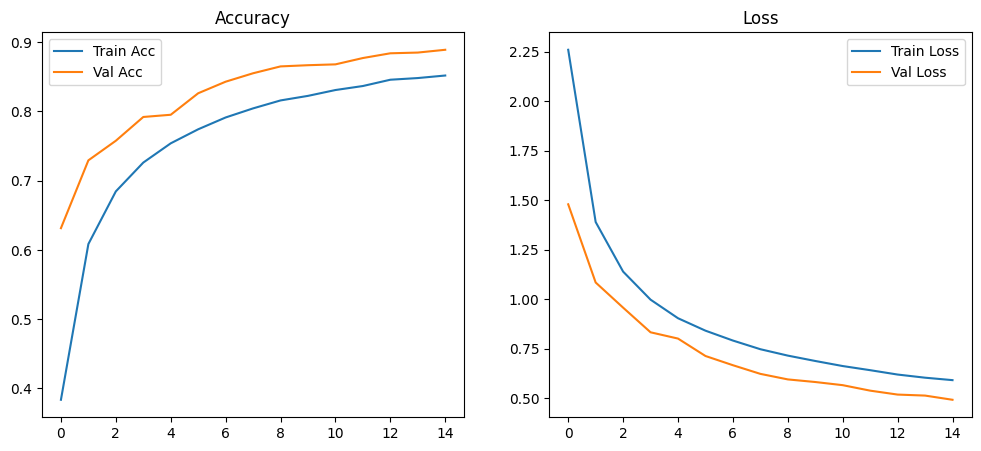

745/745 ━━━━━━━━━━━━━━━━━━━━ 120s 151ms/step

Classification Report:

              precision    recall  f1-score   support

           A       0.89      0.89      0.89      1536
           B       0.78      0.80      0.79       961
           C       0.94      0.81      0.87      2434
           D       0.73      0.87      0.79      1086
           E       0.90      0.79      0.84      1208
           F       0.55      0.97      0.70       229
           G       0.56      0.95      0.71       641
           H       0.81      0.87      0.84       795
           I       0.54      0.96      0.69       212
           J       0.95      0.88      0.91       919
           K       0.83      0.88      0.85       631
           L       0.97      0.94      0.95      1245
           M       0.92      0.93      0.93      2075
           N       0.92      0.89      0.90      1982
           O       0.97      0.90      0.93      5861
           P       0.95      0.91      0.93      2013
           

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

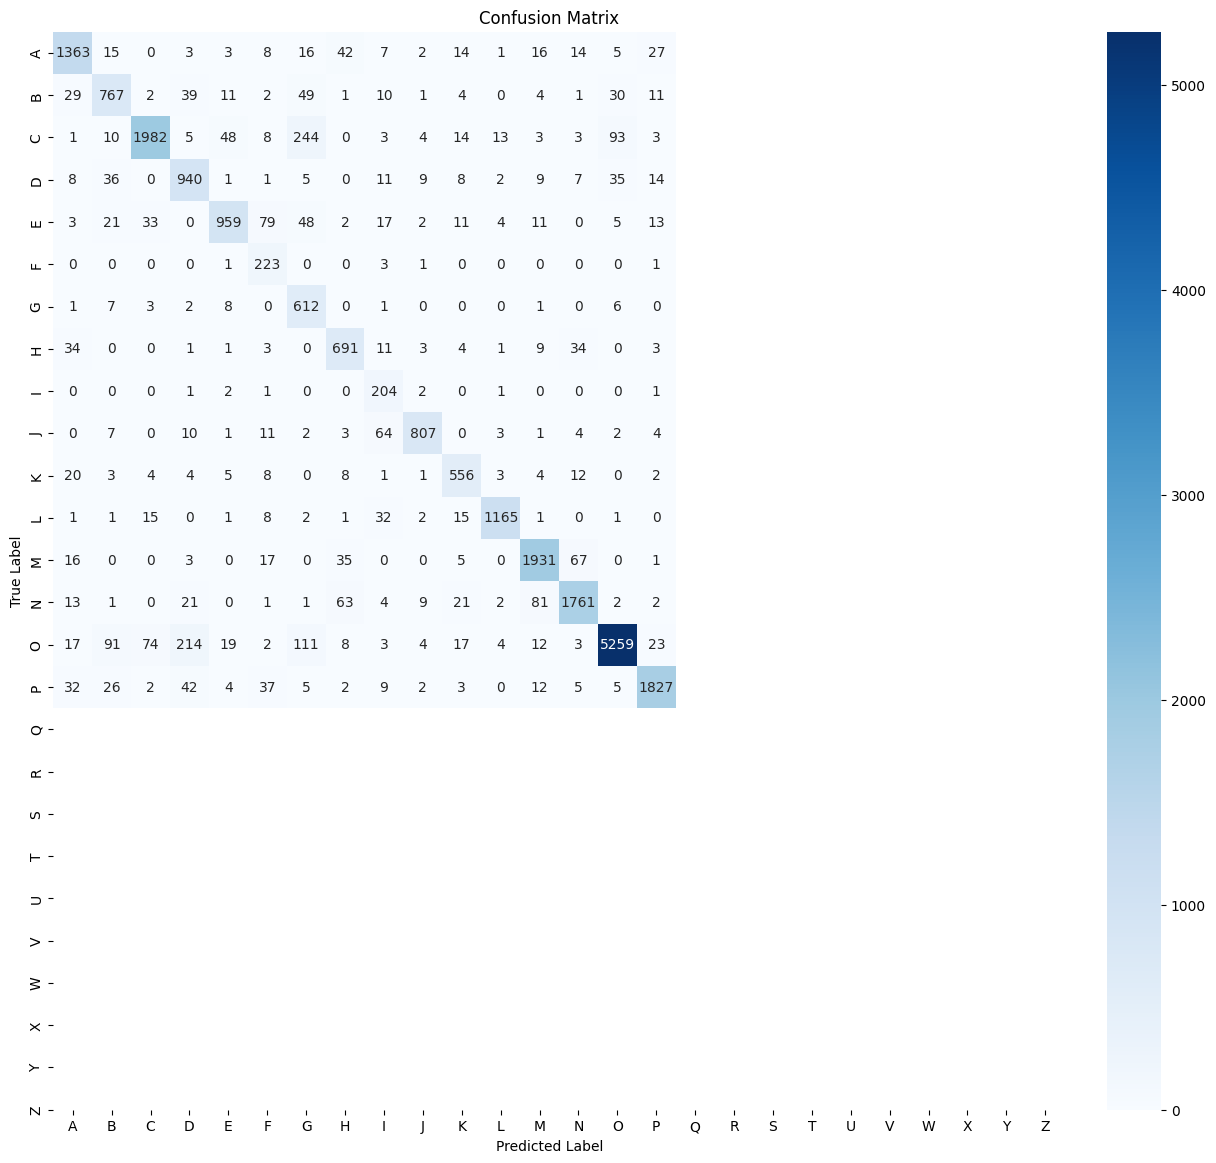

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ran

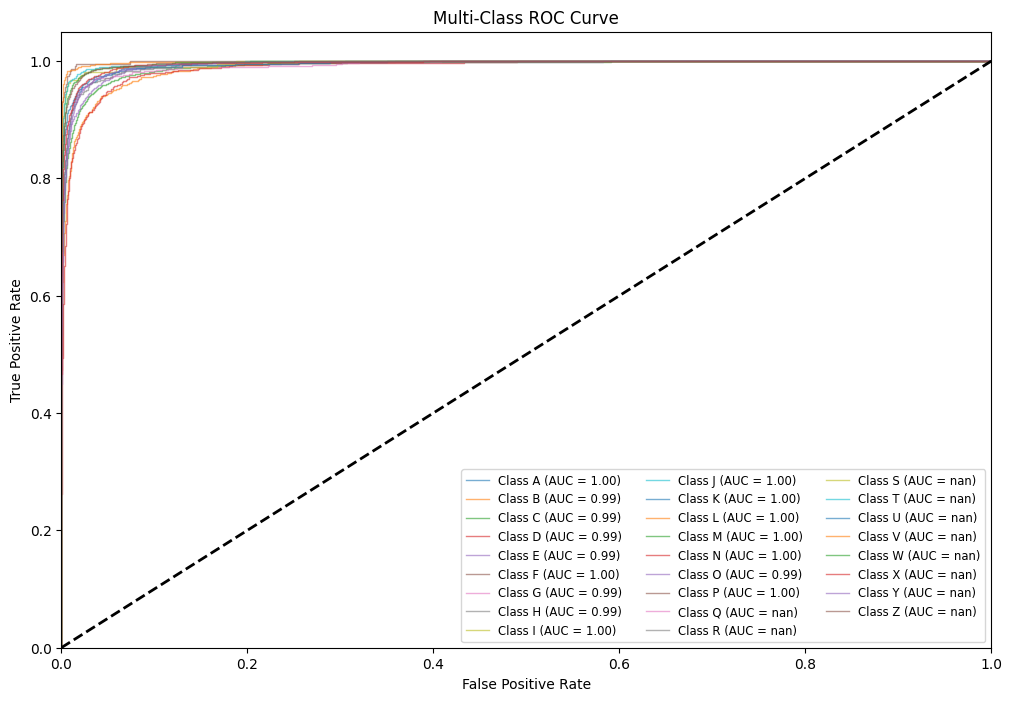

In [9]:
print("5. Evaluating...")

# A. Accuracy & Loss Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Get Predictions
y_pred_prob = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Map indices 0-25 to A-Z
labels_list = [chr(65+i) for i in range(26)]

# B. Classification Report (Recall, Precision, F1)
print("\nClassification Report:\n")
# Fix: Pass labels=range(26) to ensure all classes are reported even if some are missing in batch
print(classification_report(y_true_classes, y_pred_classes, target_names=labels_list, labels=range(26)))

# C. Confusion Matrix
plt.figure(figsize=(16, 14))
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_list, yticklabels=labels_list)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# D. ROC & AUC
plt.figure(figsize=(12, 8))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(26):
    try:
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=1, alpha=0.6,
                 label=f'Class {labels_list[i]} (AUC = {roc_auc[i]:0.2f})')
    except:
        # Handle cases where a specific class might not exist in test set
        pass

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right", ncol=3, fontsize='small')
plt.show()